# **HUMAN EMOTIONS DETECTION**

**OBJECTIVES**



1. Read in data with multiple classes
2. Prepare and transform data
3. Download a pretrained model
4. Alter the model to suit our needs with Transfer Learning.
5. Use the altered part to train our data



## **PREPARE DATA**

### **SET UP AND DATA LOADING**

In [1]:
!pip install torchinfo > /dev/null 2>&1
!pip install -q kaggle

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchvision
import sklearn
import cv2
import PIL
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from pathlib import Path
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tqdm import tqdm
from torchinfo import summary
from collections import Counter
from torch.utils.data import DataLoader

**DEVICE**

In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Device: {device}")

Device: cuda


**IMPORT DATA**

We'll load oue data from kaggle using kaggle API's

In [4]:
# Create a .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the directory
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 79% 243M/309M [00:00<00:00, 763MB/s] 
100% 309M/309M [00:03<00:00, 101MB/s]


In [6]:
!unzip -q "/content/human-emotions-datasethes.zip" -d "/content/dataset"

**ASSIGN DIRECTORY**

In [7]:
train_dir = Path("/content/dataset/Emotions Dataset/Emotions Dataset/train")
val_dir = Path("/content/dataset/Emotions Dataset/Emotions Dataset/test")
print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")

Train directory: /content/dataset/Emotions Dataset/Emotions Dataset/train
Validation directory: /content/dataset/Emotions Dataset/Emotions Dataset/test


**DISPLAY SAMPLE IMAGES**

In [16]:
def sample_images(dir, classname):
  """The function displays 5 random images from a class
  input:
    dir: path to the directory
    classname: name of the class
  """
  # Gets the file in the directory
  class_dir = os.path.join(dir, classname)
  images = os.listdir(class_dir)
  # Picks 5 random images
  images_sample = np.random.choice(images, 5)
  # Plot the images
  fig, ax = plt.subplots(1, 5, figsize=(15, 5))
  for i in range(5):
    img = Image.open(os.path.join(class_dir, images_sample[i]))
    ax[i].imshow(img)
    ax[i].set_title(classname)
    ax[i].axis("off")
  plt.show()


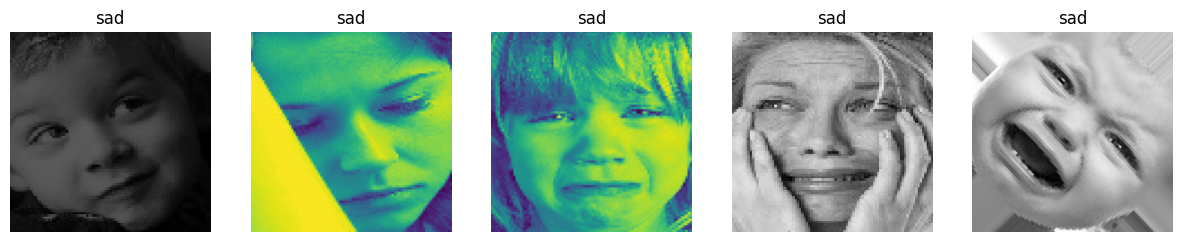

In [17]:
sample_images(train_dir, "sad")

### **DATA TRANSFORMATION**

We'll preprocess the images using transforms.compose pipeline. The steps include;


1. The images to be converted to RGB format.
2. Resize images to height and width of 224, 224.
3. Convert the images to pytorch tensors.

In [18]:
class ConvertToRGB:
  def __call__(self, img):
    if img != "RGB":
      img = img.convert("RGB")
    return img

In [19]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

**NORMALIZE**

Normalization scales the mean and std of the color channels to a standard value.

In [24]:
def fetch_mean_std(loader):
  """Calculates the mean and std of each color channel"""
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
    channels_sum += torch.mean(data, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1

  mean = channels_sum / num_batches
  std = (channels_squared_sum / num_batches - mean**2)**0.5
  return mean, std

In [25]:
train_mean, train_std = fetch_mean_std(train_loader)
print(train_mean, train_std)

tensor([0.4374, 0.4374, 0.4374]) tensor([0.2362, 0.2362, 0.2362])


In [26]:
val_mean, val_std = fetch_mean_std(val_loader)
print(val_mean, val_std)

tensor([0.4418, 0.4418, 0.4418]) tensor([0.2388, 0.2388, 0.2388])


**TRANSFORMS WITH NORMALIZATION AND DATA AUGMENTATION**

In [27]:
train_transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])
val_transorm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(val_mean, val_std)
])

**IMAGE FOLDER**

In [31]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 6799
    Root location: /content/dataset/Emotions Dataset/Emotions Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=tensor([0.4374, 0.4374, 0.4374]), std=tensor([0.2362, 0.2362, 0.2362]))
           )


In [28]:
val_dataset = datasets.ImageFolder(val_dir, transform=val_transorm)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 2278
    Root location: /content/dataset/Emotions Dataset/Emotions Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4418, 0.4418, 0.4418]), std=tensor([0.2388, 0.2388, 0.2388]))
           )


**DATA LOADER**

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [ ]:
next_batch = next(iter(train_loader))
print(next_batch[0].shape)

torch.Size([32, 3, 224, 224])


In [ ]:
next_batch = next(iter(val_loader))
print(next_batch[0].shape)

torch.Size([32, 3, 224, 224])


Confirm if the channels dimensions, mean and sd have been standardised

In [33]:
fetch_mean_std(train_loader)

(tensor([-0.0978, -0.0978, -0.0978]), tensor([1.0702, 1.0702, 1.0702]))

In [34]:
fetch_mean_std(val_loader)

(tensor([-0.0053, -0.0053, -0.0053]), tensor([1.0002, 1.0002, 1.0002]))

**CLASS BALANCE**

In [35]:
def class_counts(dataset):
  # Get class labels
  c = Counter(x[1] for x in tqdm(dataset))
  # Access the mapping from class names
  class_to_index = dataset.class_to_idx

  return pd.Series({cat: c[i] for cat, i in class_to_index.items()})

**TRAIN DISTRIBUTION**

100%|██████████| 6799/6799 [00:27<00:00, 250.02it/s]


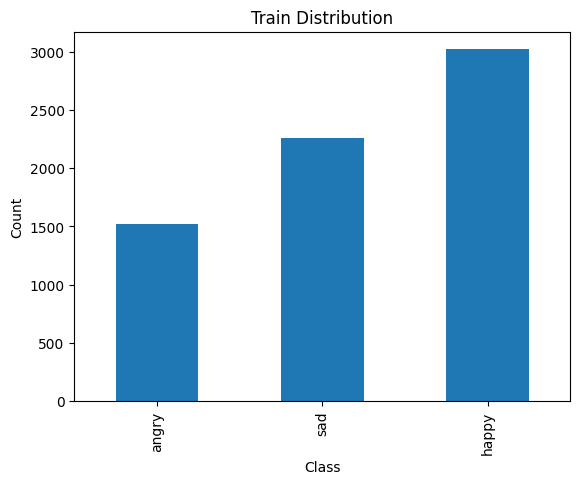

In [36]:
train_distribution = class_counts(train_dataset)
train_distribution.sort_values().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Train Distribution")
plt.show();

**VAL DISTRIBUTION**

100%|██████████| 2278/2278 [00:02<00:00, 785.40it/s]


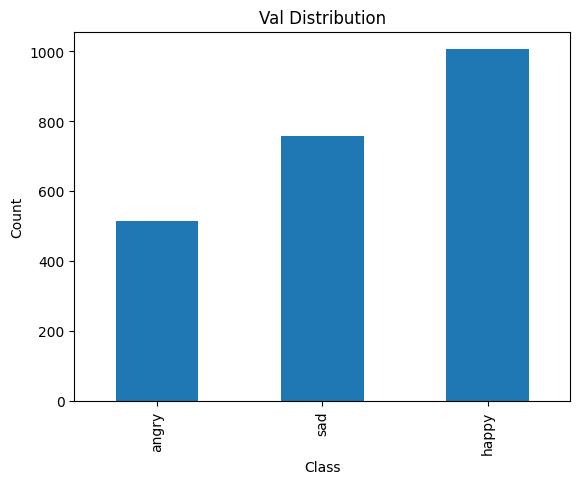

In [37]:
val_distribution = class_counts(val_dataset)
val_distribution.sort_values().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Val Distribution")
plt.show();

## **IMPLEMENTING TRANSFER LEARNING**

**EFFICIENT NET DEFINITION**

In [38]:
model = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 23.1MB/s]


In [39]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1408, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        1,448
│    │    └─MBConv: 3-5                                 [32, 16, 112, 112]        612
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-6                                

**TURN OFF BACK PROPAGATION**

In [40]:
for params in model.parameters():
  params.requires_grad = False

In [41]:
# Move the model to device
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

**MODIFY THE NETWORK**

**INPUT FEATURES EXTRACTION**

In [42]:
in_features = model.classifier[1].in_features
print(in_features)

1408


**LINEAR LAYER**

In [55]:
classifier = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 3)
)

In [56]:
# Replace the output layer in resnet with classifier
model.classifier = classifier

In [57]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 3]                   --
├─Sequential: 1-1                                       [32, 1408, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    │    └─MBConv: 3-5                                 [32, 16, 112, 112]        (612)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-6                        

**TRAINING**

In [81]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()
# Change: Optimize only the parameters of the new classifier layer (model.fc)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [82]:
def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):

  # Initialize training loss
  training_loss = 0.0

  # Set the model in training mode, no training has happenedd
  model.train()

  # Iterate over all batches
  for inputs, labels in tqdm(data_loader):
    # Reset the gradients of all model parameters
    optimizer.zero_grad()
    # Move inputs, labels to device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Forward propagation, obtain loss
    output = model(inputs)
    loss = loss_fn(output, labels)
    # Backpropagation
    loss.backward()
    # Update parameters
    optimizer.step()
    # Increment the training loss for the current batch
    training_loss += loss.data.item() * inputs.size(0)

  return training_loss / len(data_loader.dataset)

In [83]:
def predict(model, data_loader, device="cpu"):

  # Create an empty predicitons tensor, move to the gpu
  all_pred = torch.tensor([]).to(device)

  # Set the model in evaluation mode
  model.eval()

  # Turn off gradient descent
  with torch.no_grad():
    # Iterate over batches
    for inputs, labels in tqdm(data_loader):
      inputs = inputs.to(device)
      output = model(inputs)
      pred = torch.nn.functional.softmax(output, dim=1).argmax(dim=1)
      all_pred = torch.cat((all_pred, pred), dim=0)

    return all_pred

In [84]:
def accuracy(model, data_loader, loss_fn, device="cpu"):
    # Initialize the total loss and the number of accurate predictions
    total_loss = 0
    total_correct = 0

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
        # iterate over the batches,feed the model into forward propagation

        for inputs, labels in tqdm(data_loader):
            inputs = inputs.to(device)
            output = model(inputs)

            # Calculating the loss function for this batch
            labels = labels.to(device)
            loss = loss_fn(output, labels)
            total_loss += loss.data.item() * inputs.size(0)

            # For multiclass classification
            predictions = torch.argmax(output, dim=1)
            correct = (predictions == labels).sum().item()
            total_correct += correct

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )

In [85]:
# Period of learning rate decay
step_size = 4
# Multiplicative factor of learning rate decay
gamma = 0.2

# Initialize the learning rate scheduler
scheduler = StepLR(
    optimizer,
    step_size=step_size,
    gamma=gamma,
)

print(type(scheduler))


<class 'torch.optim.lr_scheduler.StepLR'>


In [86]:
def checkpointing(validation_loss, best_val_loss, model, optimizer, save_path):

    if validation_loss < best_val_loss:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_val_loss,
            },
            save_path,
        )
        print(f"Checkpoint saved with validation loss {validation_loss:.4f}")

In [87]:
# Create the directory for saving the model checkpoint
checkpoint_dir = "best"
os.makedirs(checkpoint_dir, exist_ok=True)

In [88]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=30, scheduler=None, checkpoint_path=None):
  # Initialize lists to store metrics per epoch
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []
  learning_rates = []

  # Initialize best validation loss for checkpointing
  best_val_loss = float('inf')
   # Define a path to save the best model
  save_path = "best_model.pth"

  for epoch in range(epochs):
    # Record training loss for the epoch
    training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

    # Calculate training accuracy
    _, training_accuracy = accuracy(model, train_loader, loss_fn, device)

    # Record validation loss and accuration for the batch
    validation_loss, validation_accuracy = accuracy(model, val_loader, loss_fn, device)

    # Append the metrics to the lists
    train_losses.append(training_loss)
    valid_losses.append(validation_loss)
    train_accuracies.append(training_accuracy) # Append training accuracy
    valid_accuracies.append(validation_accuracy)

    print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

    # Step the learning rate scheduler
    lr = optimizer.param_groups[0]["lr"]
    learning_rates.append(lr)
    if scheduler:
        scheduler.step()

    if checkpoint_path:
            checkpointing(
                validation_loss, best_val_loss, model, optimizer, checkpoint_path
            )
    # Update best_val_loss if current validation loss is better
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss

  # Return the collected metrics including training accuracy
  return train_losses, valid_losses, train_accuracies, valid_accuracies, learning_rates

In [89]:
train_losses, valid_losses, train_accuracies, valid_accuracies, learning_rates= train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, scheduler=scheduler,
    checkpoint_path="best/model.pth")

100%|██████████| 72/72 [00:07<00:00,  9.19it/s]


Epoch: 0, Training Loss: 0.68, Training Accuracy: 0.77, Validation Loss: 0.64, Validation Accuracy: 0.72
Checkpoint saved with validation loss 0.6415


100%|██████████| 72/72 [00:07<00:00,  9.63it/s]


Epoch: 1, Training Loss: 0.67, Training Accuracy: 0.77, Validation Loss: 0.66, Validation Accuracy: 0.71


100%|██████████| 72/72 [00:07<00:00,  9.30it/s]


Epoch: 2, Training Loss: 0.67, Training Accuracy: 0.78, Validation Loss: 0.64, Validation Accuracy: 0.72
Checkpoint saved with validation loss 0.6379


100%|██████████| 72/72 [00:07<00:00,  9.26it/s]


Epoch: 3, Training Loss: 0.67, Training Accuracy: 0.76, Validation Loss: 0.64, Validation Accuracy: 0.72


100%|██████████| 72/72 [00:07<00:00,  9.35it/s]


Epoch: 4, Training Loss: 0.64, Training Accuracy: 0.78, Validation Loss: 0.63, Validation Accuracy: 0.72
Checkpoint saved with validation loss 0.6328


100%|██████████| 72/72 [00:07<00:00,  9.22it/s]


Epoch: 5, Training Loss: 0.63, Training Accuracy: 0.77, Validation Loss: 0.63, Validation Accuracy: 0.72
Checkpoint saved with validation loss 0.6317


100%|██████████| 72/72 [00:07<00:00,  9.32it/s]


Epoch: 6, Training Loss: 0.63, Training Accuracy: 0.79, Validation Loss: 0.64, Validation Accuracy: 0.72


100%|██████████| 72/72 [00:07<00:00,  9.23it/s]


Epoch: 7, Training Loss: 0.63, Training Accuracy: 0.79, Validation Loss: 0.63, Validation Accuracy: 0.72


100%|██████████| 72/72 [00:07<00:00,  9.32it/s]


Epoch: 8, Training Loss: 0.62, Training Accuracy: 0.79, Validation Loss: 0.63, Validation Accuracy: 0.73
Checkpoint saved with validation loss 0.6296


100%|██████████| 72/72 [00:07<00:00,  9.61it/s]


Epoch: 9, Training Loss: 0.62, Training Accuracy: 0.79, Validation Loss: 0.62, Validation Accuracy: 0.73
Checkpoint saved with validation loss 0.6237


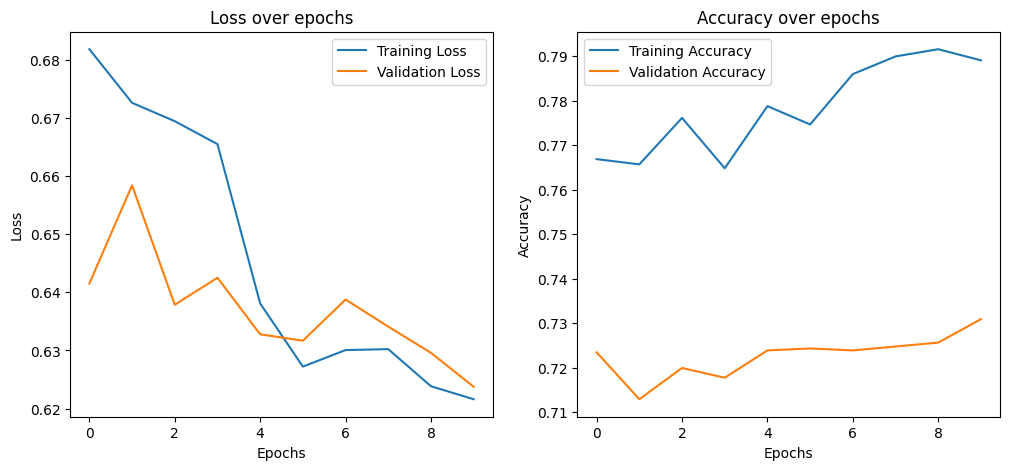

In [90]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
val_predictions = predict(model, val_loader, device)

100%|██████████| 72/72 [00:04<00:00, 15.02it/s]


100%|██████████| 72/72 [00:04<00:00, 17.76it/s]


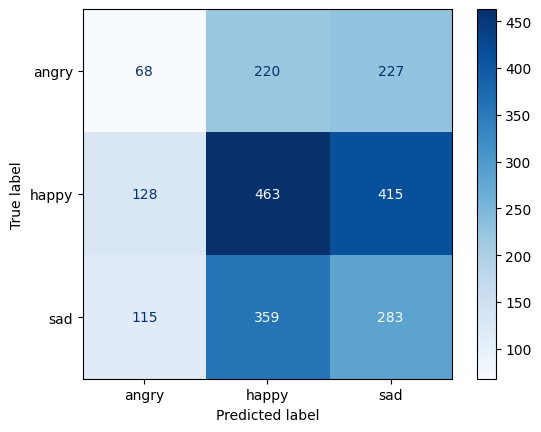

In [ ]:
targets = []
for _, labels in tqdm(val_loader):
  targets.extend(labels.tolist())
cm = confusion_matrix(targets, val_predictions.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
class_report = classification_report(targets, val_predictions.cpu(), target_names=val_dataset.classes)
print(class_report)

              precision    recall  f1-score   support

       angry       0.21      0.14      0.17       515
       happy       0.45      0.49      0.47      1006
         sad       0.33      0.37      0.35       757

    accuracy                           0.37      2278
   macro avg       0.33      0.33      0.33      2278
weighted avg       0.36      0.37      0.36      2278

